In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
# import transformers
# nltk.download('punkt')
# nltk.download('stopwords')
stop = stopwords.words('english')
import re
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
all_wines = pd.read_csv('Data/winemag-data-130k-v2.csv')
all_wines.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
clean_wines = all_wines.drop(columns=['Unnamed: 0', 'taster_twitter_handle', 'region_2'])
clean_wines = clean_wines.dropna()
clean_wines.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [4]:
clean_wines['variety'] = clean_wines['variety'].replace(['Weissburgunder'], 'Chardonnay')
clean_wines['variety'] = clean_wines['variety'].replace(['Spatburgunder'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Grauburgunder'], 'Pinot Gris')
clean_wines['variety'] = clean_wines['variety'].replace(['Garnacha'], 'Grenache')
clean_wines['variety'] = clean_wines['variety'].replace(['Pinot Nero'], 'Pinot Noir')
clean_wines['variety'] = clean_wines['variety'].replace(['Alvarinho'], 'Albarino')

In [5]:
clean_wines['vintage'] = clean_wines['title'].str.extract('(\d\d\d\d)', expand=True)
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013


In [6]:
clean_wines['type'] = ['white' if x in ['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Sparkling Blend', 'Pinot Gris',
                                        'Champagne Blend', 'GrÃ¼ner Veltliner', 'Pinot Grigio', 'Portuguese White', 'Viognier',
                                        'GewÃ¼rztraminer', 'GewÃ¼rztraminer'] else 'red' for x in clean_wines['variety']]
clean_wines


,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red


In [7]:
clean_wines['word_count'] = clean_wines['description'].str.lower().str.split().str.len()
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43


In [8]:
clean_wines = clean_wines[clean_wines['vintage'].notna()]
clean_wines = clean_wines.copy()
clean_wines['vintage'] = clean_wines['vintage'].astype(int)
clean_wines['age'] = 2020 - clean_wines['vintage'] 
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7


In [9]:
clean_wines = clean_wines.drop_duplicates('description')
clean_wines = clean_wines[pd.notnull(clean_wines.price)]

In [10]:
clean_wines.quantile(q=0.75, axis=0, numeric_only=True)

points          91.0
price           49.0
vintage       2014.0
word_count      49.0
age             10.0
Name: 0.75, dtype: float64

<AxesSubplot:>

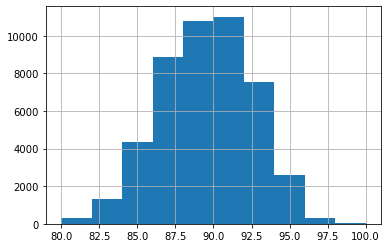

In [11]:
clean_wines['points'].hist()

In [12]:
clean_wines['good_meh'] = clean_wines['points'].apply(lambda x: 'good' if x >= 88 else 'meh')
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_meh
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7,meh
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8,meh
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9,meh
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7,meh
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8,meh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,good
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,good
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,good
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,good


In [13]:
clean_wines['grade'] = clean_wines['points'].apply(lambda x: '4' if x >= 92 else
                                                             '3' if x >= 89 else
                                                             '2' if x >= 86 else
                                                             '1')
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_meh,grade
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,white,33,7,meh,2
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,red,41,8,meh,2
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011,red,42,9,meh,2
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013,red,31,7,meh,2
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam,2012,white,30,8,meh,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,good,3
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,good,3
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,good,3
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,good,3


In [14]:
good_wines = clean_wines[clean_wines['good_meh'] == 'good']
good_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,vintage,type,word_count,age,good_meh,grade
90,US,"This blend of Sangiovese, Malbec, Cabernet Sau...",Siena,88,23.0,California,Sonoma County,Virginie Boone,Ferrari-Carano 2014 Siena Red (Sonoma County),Red Blend,Ferrari-Carano,2014,red,37,6,good,2
92,US,All red Bordeaux varieties are represented in ...,Magnificat,88,55.0,California,Napa Valley,Virginie Boone,Franciscan 2013 Magnificat Meritage (Napa Valley),Meritage,Franciscan,2013,red,41,7,good,2
94,US,"Barrel notes are prominent, with aromas of Cre...",Grand Klasse Reserve Lawrence Vineyards,88,22.0,Washington,Columbia Valley (WA),Sean P. Sullivan,Gård 2014 Grand Klasse Reserve Lawrence Vineya...,Viognier,Gård,2014,white,36,6,good,2
97,US,A wisp of bramble extends a savory tone from n...,Ingle Vineyard,88,20.0,New York,Finger Lakes,Anna Lee C. Iijima,Heron Hill 2015 Ingle Vineyard Riesling (Finge...,Riesling,Heron Hill,2015,white,53,5,good,2
98,Italy,"Forest floor, menthol, espresso, cranberry and...",Dono Riserva,88,30.0,Tuscany,Morellino di Scansano,Kerin O’Keefe,Serpaia di Endrizzi 2010 Dono Riserva (Morell...,Sangiovese,Serpaia di Endrizzi,2010,red,47,10,good,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,Cave de Turckheim,2010,white,52,10,good,3
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,Cusumano,2012,red,37,8,good,3
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann,2013,white,32,7,good,3
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,red,43,7,good,3


In [15]:
clean_wines['char_count'] = clean_wines["description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
clean_wines['sentence_count'] = clean_wines["description"].apply(lambda x: len(str(x).split(".")))
clean_wines['avg_word_length'] = clean_wines['char_count'] / clean_wines['word_count']
clean_wines['avg_sentence_lenght'] = clean_wines['word_count'] / clean_wines['sentence_count']
clean_wines

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,vintage,type,word_count,age,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,...,2013,white,33,7,meh,2,167,3,5.060606,11.000000
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,...,2012,red,41,8,meh,2,209,3,5.097561,13.666667
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,...,2011,red,42,9,meh,2,220,4,5.238095,10.500000
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,...,2013,red,31,7,meh,2,151,3,4.870968,10.333333
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,...,2012,white,30,8,meh,2,131,4,4.366667,7.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129959,France,The granite soil of the Brand Grand Cru vineya...,Brand Grand Cru,90,57.0,Alsace,Alsace,Roger Voss,Cave de Turckheim 2010 Brand Grand Cru Pinot G...,Pinot Gris,...,2010,white,52,10,good,3,237,5,4.557692,10.400000
129962,Italy,"Blackberry, cassis, grilled herb and toasted a...",Sàgana Tenuta San Giacomo,90,40.0,Sicily & Sardinia,Sicilia,Kerin O’Keefe,Cusumano 2012 Sàgana Tenuta San Giacomo Nero d...,Nero d'Avola,...,2012,red,37,8,good,3,184,4,4.972973,9.250000
129965,France,"While it's rich, this beautiful dry wine also ...",Seppi Landmann Vallée Noble,90,28.0,Alsace,Alsace,Roger Voss,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,...,2013,white,32,7,good,3,180,3,5.625000,10.666667
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,...,2013,red,43,7,good,3,183,4,4.255814,10.750000


In [16]:
winery_counts = {'winery' : clean_wines['winery'].unique(), 
                 'winery_count' : clean_wines['winery'].value_counts() 

            }
winery_df = pd.DataFrame(data=winery_counts)
winery_df.reset_index(drop=True, inplace=True)
winery_df

,winery,winery_count
0,St. Julian,144
1,Sweet Cheeks,117
2,Tandem,103
3,Terre di Giurfo,100
4,Jean-Baptiste Adam,90
...,...,...
8286,Yacochuya,1
8287,Tollot Beaut et Fils,1
8288,Bottega,1
8289,Bodegas Eidosela,1


In [17]:
clean_wines = clean_wines.merge(winery_df, how='inner', on='winery')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,type,word_count,age,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count
37627,Spain,"Big, extracted and clumsy on first blush, with...",Más de Leda,88,20.0,Northern Spain,Vino de la Tierra de Castilla y León,Michael Schachner,Bodegas Leda 2007 Más de Leda Tempranillo (Vin...,Tempranillo,...,red,41,13,good,2,208,5,5.073171,8.200000,3
30230,Italy,"Delicately scented, this opens with aromas of ...",Wighel,92,18.0,Lombardy,Lugana,Kerin O’Keefe,Tenuta Roveglia 2015 Wighel (Lugana),Turbiana,...,red,35,5,good,4,193,3,5.514286,11.666667,5
2975,US,Black cherry fruit gets serious with elements ...,Alfaro Family Vineyards,90,48.0,California,Santa Cruz Mountains,Matt Kettmann,Big Basin 2012 Alfaro Family Vineyards Pinot N...,Pinot Noir,...,red,50,8,good,3,235,3,4.700000,16.666667,33
7026,US,"A block-designated, 100% whole cluster-ferment...",Serendipity Block,90,48.0,California,Sonoma Mountain,Virginie Boone,Belden Barns 2014 Serendipity Block Pinot Noir...,Pinot Noir,...,red,32,6,good,3,204,3,6.375000,10.666667,21
3147,US,"From all-estate fruit, this dives into experim...",Trajet Reserve,91,80.0,Oregon,Chehalem Mountains,Paul Gregutt,Le Cadeau 2014 Trajet Reserve Pinot Noir (Cheh...,Pinot Noir,...,red,60,6,good,3,289,5,4.816667,12.000000,32
41160,US,"A perfumed wine with notes of candied orange, ...",Sweet,85,10.0,Washington,Washington,Sean P. Sullivan,Paradise Peak 2012 Sweet Riesling (Washington),Riesling,...,white,22,8,meh,1,105,4,4.772727,5.500000,2
45314,Argentina,Dilute cherry aromas are not convincing. Wiry ...,Made From Organically Grown Grapes,82,12.0,Mendoza Province,Mendoza,Michael Schachner,Cuatro Vacas Gordas 2013 Made From Organically...,Malbec-Cabernet Sauvignon,...,red,31,7,meh,1,136,4,4.387097,7.750000,1
21395,Argentina,This blend smells outright herbaceous and weed...,Paisaje de Barrancas,81,18.0,Mendoza Province,Mendoza,Michael Schachner,Finca Flichman 2014 Paisaje de Barrancas Red (...,Red Blend,...,red,23,6,meh,1,124,3,5.391304,7.666667,8
18614,France,The idea that Sauvignon Blanc cannot age is em...,Le Grand Rochoy,93,45.0,Loire Valley,Sancerre,Roger Voss,Domaine Laporte 2006 Le Grand Rochoy (Sancerre),Sauvignon Blanc,...,white,39,14,good,4,193,4,4.948718,9.750000,9
6753,US,A unique blend of several of the winery's vine...,Wallah Wallah Special #4,94,165.0,Washington,Walla Walla Valley (WA),Sean P. Sullivan,Cayuse 2012 Wallah Wallah Special #4 Syrah (Wa...,Syrah,...,red,58,8,good,4,284,4,4.896552,14.500000,21


In [18]:
country_counts = {'country' : clean_wines['country'].unique(),
             'country_count' : clean_wines['country'].value_counts()
            }
country_df = pd.DataFrame(data=country_counts)
country_df.reset_index(drop=True, inplace=True)
country_df

,country,country_count
0,US,23237
1,Spain,9408
2,Italy,6120
3,France,4337
4,Argentina,2579
5,Australia,1309
6,Canada,154


In [19]:
clean_wines = clean_wines.merge(country_df, how='inner', on='country')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,word_count,age,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count
6415,US,This has a gorgeous nose redolent with dried s...,Wahluke Slope Vineyard,90,30.0,Washington,Wahluke Slope,Paul Gregutt,Arbor Crest 2004 Wahluke Slope Vineyard Cabern...,Cabernet Sauvignon,...,61,16,good,3,293,5,4.803279,12.200000,14,23237
44487,Argentina,"Meaty, minty scents accent core cassis, jammy ...",Catena Alta Historic Rows,91,60.0,Mendoza Province,Mendoza,Michael Schachner,Bodega Catena Zapata 2011 Catena Alta Historic...,Malbec,...,47,9,good,3,251,5,5.340426,9.400000,9,2579
41137,France,"This has a minerally, tense structure as well ...",Bois Seguin,87,25.0,Burgundy,Pouilly-Fuissé,Roger Voss,Domaine Luquet 2011 Bois Seguin (Pouilly-Fuissé),Chardonnay,...,33,9,meh,2,148,3,4.484848,11.000000,3,4337
21107,US,A lightweight effort with admirably low alcoho...,Hoot And Howl Vineyard,86,16.0,Oregon,Willamette Valley,Paul Gregutt,Zimri Cellars 2015 Hoot And Howl Vineyard Pino...,Pinot Gris,...,43,5,meh,2,217,3,5.046512,14.333333,2,23237
30556,Italy,"Intense aromas of red currants, cedar, spice, ...",Atis,90,70.0,Tuscany,Toscana,Kerin O’Keefe,Guado al Melo 2011 Atis Red (Toscana),Red Blend,...,52,9,good,3,285,4,5.480769,13.000000,4,6120
45357,Argentina,"Overdone aromas of candle wax, incense and air...",Estate Bottled,83,8.0,Mendoza Province,Mendoza,Michael Schachner,Rio Seco 2008 Estate Bottled Torrontés (Mendoza),Torrontés,...,38,12,meh,1,181,3,4.763158,12.666667,2,2579
3218,US,The old blocks referenced in this pure Caberne...,Big Papa Old Block,92,54.0,Washington,Columbia Valley (WA),Paul Gregutt,Efeste 2010 Big Papa Old Block Cabernet Sauvig...,Cabernet Sauvignon,...,54,10,good,4,291,4,5.388889,13.500000,25,23237
40646,France,Selected from a portion of the family vineyard...,Enzo,87,22.0,Provence,Côtes de Provence,Roger Voss,Château Hermitage Saint-Martin 2016 Enzo Rosé ...,Rosé,...,37,4,meh,2,171,3,4.621622,12.333333,3,4337
25139,Spain,Aromas of raisin and cassis lean in the direct...,Unico,92,450.0,Northern Spain,Ribera del Duero,Michael Schachner,Vega Sicilia 2007 Unico (Ribera del Duero),Red Blend,...,52,13,good,4,253,4,4.865385,13.000000,6,9408
2719,US,This wine is a blend Viognier (60%) and Roussa...,Helène,89,24.0,Washington,Yakima Valley,Sean P. Sullivan,Bunnell 2013 Helène White (Yakima Valley),White Blend,...,29,7,good,3,133,4,4.586207,7.250000,28,23237


In [20]:
province_counts = {'province' : clean_wines['province'].unique(),
             'province_count' : clean_wines['province'].value_counts()
            }
province_df = pd.DataFrame(data=province_counts)
province_df.reset_index(drop=True, inplace=True)
province_df

,province,province_count
0,Michigan,12491
1,Oregon,5325
2,California,3423
3,Washington,2770
4,Virginia,2209
5,New York,1928
6,Idaho,1824
7,Texas,1574
8,Pennsylvania,1462
9,New Jersey,1383


In [21]:
clean_wines = clean_wines.merge(province_df, how='inner', on='province')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,age,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count
44000,Argentina,"Dark in color and ripe from the get go, this M...",Armado Sur Malbec-Bonadra-Syrah,89,15.0,Mendoza Province,Mendoza,Michael Schachner,Trivento 2014 Armado Sur Malbec-Bonadra-Syrah ...,Red Blend,...,6,good,3,232,4,4.833333,12.000000,12,2579,9
33872,France,The Sylvaner's essential spice and pepper qual...,Trois Châteaux,87,25.0,Alsace,Alsace,Roger Voss,Kuentz-Bas 2009 Trois Châteaux Sylvaner (Alsace),Sylvaner,...,11,meh,2,141,3,5.423077,8.666667,28,4337,57
44576,Argentina,This warm-weather Viognier is fleshy and chunk...,Reserva,84,12.0,Mendoza Province,Uco Valley,Michael Schachner,Finca El Origen 2012 Reserva Viognier (Uco Val...,Viognier,...,8,meh,1,211,3,4.795455,14.666667,7,2579,9
26334,Spain,"As is normal for Embruix, the nose is generous...",Embruix,90,25.0,Catalonia,Priorat,Michael Schachner,Vall Llach 2011 Embruix Red (Priorat),Red Blend,...,9,good,3,212,5,4.608696,9.200000,24,9408,391
2175,US,"A lovely bottle, carefully crafted from vines ...",Maresh Vineyard,89,21.0,Oregon,Dundee Hills,Paul Gregutt,Daedalus Cellars 2007 Maresh Vineyard Riesling...,Riesling,...,13,good,3,320,5,4.637681,13.800000,8,23237,5325
5957,US,A Cabernet Sauvignon from historic Livermore V...,The Premier,92,100.0,California,Livermore Valley,Virginie Boone,Steven Kent 2010 The Premier Cabernet Sauvigno...,Cabernet Sauvignon,...,10,good,4,408,5,5.298701,15.400000,18,23237,3423
43499,Argentina,A high-end Malbec experience at a reasonable p...,Finca Las Palmas,91,25.0,Mendoza Province,Mendoza,Michael Schachner,Trapiche 2008 Finca Las Palmas Malbec (Mendoza),Malbec,...,12,good,3,287,5,5.314815,10.800000,20,2579,9
37430,France,"Attractively spicy as well as fruity, this is ...",Les Cras,91,21.0,Burgundy,Saint-Véran,Roger Voss,Domaine des Valanges 2014 Les Cras (Saint-Véran),Chardonnay,...,6,good,3,158,4,4.937500,8.000000,3,4337,48
20030,US,"Blended with a whopping 15% Petit Verdot, this...",V.R. Special,91,60.0,Washington,Columbia Valley (WA),Sean P. Sullivan,Dusted Valley 2013 V.R. Special Cabernet Sauvi...,Cabernet Sauvignon,...,7,good,3,219,4,5.214286,10.500000,6,23237,2770
9408,US,An opulent nose surges from the bottle in this...,Ritchie Vineyard,93,60.0,California,Russian River Valley,Virginie Boone,Arista 2013 Ritchie Vineyard Chardonnay (Russi...,Chardonnay,...,7,good,4,270,4,5.192308,13.000000,8,23237,3423


In [22]:
region_counts = {'region_1' : clean_wines['region_1'].unique(),
             'region_count' : clean_wines['region_1'].value_counts()
            }
region_df = pd.DataFrame(data=region_counts)
region_df.reset_index(drop=True, inplace=True)
region_df

,region_1,region_count
0,Lake Michigan Shore,2240
1,Michigan,1509
2,Old Mission Peninsula,1483
3,Leelanau Peninsula,1344
4,Willamette Valley,1178
...,...,...
982,Short Hills Bench,1
983,St. David's Bench,1
984,Prince Edward County,1
985,Okanagan Valley,1


In [23]:
clean_wines = clean_wines.merge(region_df, how='inner', on='region_1')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,good_meh,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count
41028,France,The crispness and acidity are very evident in ...,Les Belles Vignes Rosé,88,26.0,Loire Valley,Sancerre,Roger Voss,Fournier Père et Fils 2009 Les Belles Vignes R...,Pinot Noir,...,good,2,114,3,6.000000,6.333333,22,4337,14,1
1431,US,"Built for immediate enjoyment, this brings a t...",Extrovert,91,48.0,Oregon,Willamette Valley,Paul Gregutt,Tendril 2014 Extrovert Pinot Noir (Willamette ...,Pinot Noir,...,good,3,222,3,4.826087,15.333333,2,23237,5325,1178
25072,Spain,This wine gets it right. The color is dark and...,Jaros,90,35.0,Northern Spain,Ribera del Duero,Michael Schachner,Finca El Quiñón 2006 Jaros (Ribera del Duero),Tempranillo,...,good,3,256,6,4.740741,9.000000,1,9408,531,36
29299,Italy,"Enticing scents of rose, moist soil, plum, ras...",Riserva,89,25.0,Tuscany,Chianti Classico,Kerin O’Keefe,Luiano 2013 Riserva (Chianti Classico),Sangiovese,...,good,3,210,4,5.384615,9.750000,4,6120,254,18
5006,US,"Made from Zinfandel, this wine has dark color ...",Arozza,90,28.0,California,Russian River Valley,Virginie Boone,Gracianna 2015 Arozza Rosé (Russian River Valley),Rosé,...,good,3,163,2,5.093750,16.000000,11,23237,3423,415
26613,Spain,"Yeast, scrambled egg, apple and lime aromas ar...",Laietà Gran Reserva Brut Nature,90,36.0,Catalonia,Cava,Michael Schachner,Alta Alella 2011 Laietà Gran Reserva Brut Natu...,Sparkling Blend,...,good,3,200,4,4.878049,10.250000,19,9408,391,27
1124,US,"Stainless-steel fermentation yields a tangy, r...",Temperance Hill Vineyard,87,19.0,Oregon,Willamette Valley,Paul Gregutt,Lumos 2009 Temperance Hill Vineyard Gewürztram...,Gewürztraminer,...,meh,2,230,4,6.052632,9.500000,5,23237,5325,1178
36984,France,The fruit and structure of this monopole bottl...,Clos du Chapitre Premier Cru,91,90.0,Burgundy,Gevrey-Chambertin,Roger Voss,Nuiton-Beaunoy 2014 Clos du Chapitre Premier C...,Pinot Noir,...,good,3,203,4,4.720930,10.750000,7,4337,48,4
42457,France,"A buoyant wine, this has delicious acidity and...",La Riviera,89,17.0,Provence,Côtes de Provence,Roger Voss,Domaine de la Sanglière 2015 La Riviera Rosé (...,Rosé,...,good,3,158,3,5.266667,10.000000,17,4337,9,1
30473,Italy,Here's a bold wine that opens with aromas of u...,Vigna Cataratte Riserva,90,40.0,Southern Italy,Aglianico del Taburno,Kerin O’Keefe,Fontanavecchia 2007 Vigna Cataratte Riserva (...,Aglianico,...,good,3,307,6,4.951613,10.333333,2,6120,181,13


In [24]:
taster_counts = {'taster_name' : clean_wines['taster_name'].unique(),
             'taster_count' : clean_wines['taster_name'].value_counts()
            }
taster_df = pd.DataFrame(data=taster_counts)
taster_df.reset_index(drop=True, inplace=True)
taster_df

,taster_name,taster_count
0,Alexander Peartree,7433
1,Anna Lee C. Iijima,7022
2,Susan Kostrzewa,6065
3,Paul Gregutt,5978
4,Michael Schachner,5915
5,Joe Czerwinski,4068
6,Sean P. Sullivan,3013
7,Virginie Boone,2261
8,Jim Gordon,2119
9,Matt Kettmann,1490


In [25]:
clean_wines = clean_wines.merge(taster_df, how='inner', on='taster_name')
clean_wines.sample(30)

,country,description,designation,points,price,province,region_1,taster_name,title,variety,...,grade,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
24162,US,"Steely at first, this wine softens like butter...",Mill Station Vineyard,92,35.0,California,Green Valley,Virginie Boone,Martin Ray 2013 Mill Station Vineyard Chardonn...,Chardonnay,...,4,196,3,5.025641,13.000000,18,23237,3423,164,2261
22765,US,Earth and rose petal notes open on the nose of...,Terra de Promissio,92,70.0,California,Sonoma Coast,Virginie Boone,Della 2014 Terra de Promissio Pinot Noir (Sono...,Pinot Noir,...,4,209,3,4.644444,15.000000,5,23237,3423,304,2261
45827,Italy,White spring flower and orchard fruit aromas f...,Numero 10 Metodo Classico,88,28.0,Veneto,Valdobbiadene Prosecco Superiore,Kerin O’Keefe,Valdo 2014 Numero 10 Metodo Classico (Valdobb...,Glera,...,2,165,3,4.852941,11.333333,1,6120,89,6,84
46994,France,"Creamy, ripe pear fruit signals a pliable, ric...",Bonheur Convivial,89,18.0,Alsace,Alsace,Anne Krebiehl MW,Domaine Rieflé-Landmann 2014 Bonheur Convivial...,Pinot Gris,...,3,210,4,4.468085,11.750000,3,4337,57,5,8
26399,US,"Rich texture, full body and ripe, mellow flavo...",Bianco di Ca' Momi,88,15.0,California,California,Jim Gordon,Ca' Momi 2014 Bianco di Ca' Momi White (Califo...,White Blend,...,2,141,3,4.700000,10.000000,1,23237,3423,301,2119
26404,US,"Herbaceous in aroma, dry and lean on the palat...",All Profits to Charity,84,18.0,California,California,Jim Gordon,100 Percent Wine 2014 All Profits to Charity S...,Sauvignon Blanc,...,1,111,3,4.826087,7.666667,1,23237,3423,301,2119
32935,France,"Taut and edgy, very steely in character, with ...",Blanchots,93,70.0,Burgundy,Chablis,Roger Voss,Simonnet-Febvre 2008 Blanchots (Chablis),Chardonnay,...,4,179,4,4.710526,9.500000,12,4337,48,5,927
3389,US,"Though labeled simply “Oregon,” this is 100% H...",Melodia,93,34.0,Oregon,Oregon,Paul Gregutt,DanCin 2014 Melodia Pinot Noir (Oregon),Pinot Noir,...,4,328,4,4.895522,16.750000,8,23237,5325,1166,5978
14743,Argentina,Jammy berry and cassis aromas come with a bit ...,Phebus Estate Bottled,88,16.0,Other,Río Negro Valley,Michael Schachner,Fabre Montmayou 2011 Phebus Estate Bottled Mal...,Malbec,...,2,215,4,4.215686,12.750000,5,2579,6,1,5915
10781,Spain,"Fruity and balanced up front, this is juicy an...",Ea,89,21.0,Central Spain,La Mancha,Michael Schachner,Manuel Manzaneque Suárez 2012 Ea Tempranillo (...,Tempranillo,...,3,197,3,4.804878,13.666667,6,9408,415,31,5915


In [26]:

# LabelEncoder dependency
from sklearn.preprocessing import LabelEncoder

# create features
number = LabelEncoder()
features = clean_wines[['grade', 'country','price','province','variety','winery','vintage', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_lenght', 'winery_count', 'country_count', 'province_count', 'region_count', 'taster_count']]
features['country'] = number.fit_transform(features['country'].astype('str'))
features['province'] = number.fit_transform(features['province'].astype('str'))
features['variety'] = number.fit_transform(features['variety'].astype('str'))
features['winery'] = number.fit_transform(features['winery'].astype('str'))

# features 
features.sample(10)

C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\audri\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

,grade,country,price,province,variety,winery,vintage,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
40290,3,4,15.0,44,138,1261,2015,145,3,4.833333,10.000000,17,6120,301,22,84
5137,2,6,18.0,8,424,6855,1998,163,3,4.289474,12.666667,10,23237,3423,354,5978
12612,4,0,50.0,25,163,193,2010,307,6,5.293103,9.666667,17,2579,9,1,5915
45150,3,4,12.0,41,214,3733,2015,234,4,4.875000,12.000000,10,6120,154,8,84
41011,3,4,90.0,52,307,486,2011,171,3,5.181818,11.000000,2,6120,254,19,84
45011,2,4,50.0,41,233,6267,2012,177,4,5.057143,8.750000,1,6120,154,9,84
31828,4,6,65.0,8,269,7518,2012,241,3,5.127660,15.666667,18,23237,3423,164,1490
2286,3,6,42.0,38,269,628,2010,235,4,4.895833,12.000000,22,23237,5325,1178,5978
38298,3,3,111.0,22,77,2927,2009,179,5,4.589744,7.800000,6,4337,14,1,927
3265,4,6,75.0,38,269,3835,2014,269,5,4.719298,11.400000,1,23237,5325,1178,5978


In [27]:
# winery_scores = {'winery' : clean_wines['winery'].unique(), 
#                  'winery_avg' : clean_wines[clean_wines['winery'].value_counts() 

#             }
# winery_df = pd.DataFrame(data=winery_counts)
# winery_df.reset_index(drop=True, inplace=True)
# winery_df

In [28]:
# features = clean_wines[['country', 'province', 'variety', 'winery', 'price', 'age', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 
#                         'avg_sentence_lenght', 'winery_count', 'country_count', 'province_count', 'region_count',
#                        'taster_count', 'grade']]
# features

In [29]:
no_price = features.drop(columns='price')
no_price

,grade,country,province,variety,winery,vintage,char_count,sentence_count,avg_word_length,avg_sentence_lenght,winery_count,country_count,province_count,region_count,taster_count
0,2,6,26,291,7097,2013,167,3,5.060606,11.000000,144,23237,12491,2240,7433
1,2,6,26,411,7097,2013,250,4,5.208333,12.000000,144,23237,12491,2240,7433
2,1,6,26,264,7097,2013,136,3,4.857143,9.333333,144,23237,12491,2240,7433
3,2,6,26,291,7097,2013,208,4,5.333333,9.750000,144,23237,12491,2240,7433
4,2,6,26,385,7097,2013,172,3,4.526316,12.666667,144,23237,12491,2240,7433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47139,3,3,0,269,7834,2012,186,4,5.812500,8.000000,2,4337,57,5,8
47140,4,3,0,335,7834,2013,222,4,5.692308,9.750000,2,4337,57,5,8
47141,3,3,0,335,2980,2015,256,4,5.224490,12.250000,1,4337,57,5,8
47142,3,3,0,335,383,1904,233,5,4.854167,9.600000,1,4337,57,5,8


In [30]:
X = features
y = clean_wines['grade']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=16))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [34]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

11786/11786 - 1s - loss: 0.0024 - accuracy: 0.9999
Normal Neural Network - Loss: 0.002350198196828141, Accuracy: 0.9999151825904846


In [35]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [36]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [37]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

,prediction,actual
46003,4,4
38780,4,4
34859,1,1
41020,2,2
42705,1,1
40229,2,2
19852,1,1
16188,4,4
26328,1,1
34918,1,1


In [38]:
predictions_df.to_csv('Data/predictions_all_features.csv')

In [39]:
X = no_price
y = clean_wines['grade']

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=15))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

In [42]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [43]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

11786/11786 - 1s - loss: 2.6298e-10 - accuracy: 1.0000
Normal Neural Network - Loss: 2.6297652126509035e-10, Accuracy: 1.0


In [44]:
encoded_predictions = model.predict_classes(X_test_scaled[:])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [45]:
d = {'prediction' : prediction_labels, 
     'actual' : y_test}

In [46]:
predictions_df = pd.DataFrame(data=d)
predictions_df.sample(30)

,prediction,actual
2343,4,4
32326,1,1
3119,3,3
41667,3,3
21391,3,3
6666,2,2
7423,2,2
20706,2,2
19168,2,2
25405,4,4


In [47]:
predictions_df.to_csv('Data/predictions_all_features_no_price.csv')

In [ ]:
# garbage code from here

In [ ]:
# X = features
# y = clean_wines['grade']

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from tensorflow.keras.utils import to_categorical

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=1)
# X_scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)


# # Step 1: Label-encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)

# # Step 2: Convert encoded labels to one-hot-encoding
# y_train_categorical = to_categorical(encoded_y_train)
# y_test_categorical = to_categorical(encoded_y_test)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# model = Sequential()
# model.add(Dense(units=200, activation='relu', input_dim=15))
# model.add(Dense(units=200, activation='relu'))
# model.add(Dense(units=4, activation='softmax'))

In [ ]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(
#     X_train_scaled,
#     y_train_categorical,
#     epochs=60,
#     shuffle=True,
#     verbose=0
# )

In [ ]:
# model_loss, model_accuracy = model.evaluate(
#     X_test_scaled, y_test_categorical, verbose=2)
# print(
#     f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# encoded_predictions = model.predict_classes(X_test_scaled[:])
# prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [ ]:
# d = {'prediction' : prediction_labels, 
#      'actual' : y_test}

In [ ]:
# predictions_df = pd.DataFrame(data=d)
# predictions_df

In [ ]:
# features = clean_wines[['price', 'age', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 
#                         'avg_sentence_lenght', 'winery_count', 'country_count', 'province_count', 'region_count',
#                        'taster_count']]
# features

In [ ]:
# X = features
# y = clean_wines['type']

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from tensorflow.keras.utils import to_categorical

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=1)
# X_scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)


# # Step 1: Label-encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)

# # Step 2: Convert encoded labels to one-hot-encoding
# y_train_categorical = to_categorical(encoded_y_train)
# y_test_categorical = to_categorical(encoded_y_test)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# model = Sequential()
# model.add(Dense(units=200, activation='relu', input_dim=12))
# model.add(Dense(units=200, activation='relu'))
# model.add(Dense(units=2, activation='softmax'))

In [ ]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(
#     X_train_scaled,
#     y_train_categorical,
#     epochs=60,
#     shuffle=True,
#     verbose=0
# )

In [ ]:
# model_loss, model_accuracy = model.evaluate(
#     X_test_scaled, y_test_categorical, verbose=2)
# print(
#     f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# encoded_predictions = model.predict_classes(X_test_scaled[:])
# prediction_labels = label_encoder.inverse_transform(encoded_predictions)

In [ ]:
# d = {'prediction' : prediction_labels, 
#      'actual' : y_test}

In [ ]:
# predictions_df = pd.DataFrame(data=d)
# predictions_df.sample(30)

In [ ]:
# white_prd = predictions_df[predictions_df['prediction'] == 'white']
# white_prd

In [ ]:
# red_prd = predictions_df[predictions_df['prediction'] == 'red']
# red_prd

In [ ]:
# white_test_wines = predictions_df[predictions_df['actual'] == 'white']
# white_test_wines.

In [ ]:
# X = features
# y = clean_wines['variety']

In [ ]:
# clean_wines['variety'].nunique()

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from tensorflow.keras.utils import to_categorical

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=1)
# X_scaler = MinMaxScaler().fit(X_train)
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)


# # Step 1: Label-encode data set
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# encoded_y_train = label_encoder.transform(y_train)
# encoded_y_test = label_encoder.transform(y_test)

# # Step 2: Convert encoded labels to one-hot-encoding
# y_train_categorical = to_categorical(encoded_y_train)
# y_test_categorical = to_categorical(encoded_y_test)